In [1]:
# Importing Modules 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.kalman_filter import FilterResults
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for plotting grids with matplotlib
def plot_grid(df, nrows, ncols):
    
    fix, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, linewidth=1)
        
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
        
    plt.tight_layout();

In [93]:
# Read CSVs
df_DJI = pd.read_csv('./DATA/INDICES/DJI_OHLCV.csv', parse_dates=['Date'], infer_datetime_format=True, index_col="Date" )

# Compute stdev
stdev_window = 25
df_DJI['stdev'] = df_DJI['Close'].pct_change().rolling(window=stdev_window).std()

df_DJI.dropna(inplace=True)
print(df_DJI.shape)
df_DJI.head()

(2986, 6)


,Open,High,Low,Close,Volume,stdev
Date,,,,,,
2010-11-05,11435.22,11451.53,11393.52,11444.08,211673104,0.007120
2010-11-08,11439.54,11439.61,11362.53,11406.84,143993472,0.006941
2010-11-09,11403.59,11421.14,11303.19,11346.75,161909792,0.006292
2010-11-10,11342.81,11366.16,11255.02,11357.04,164169600,0.006291
2010-11-11,11326.69,11326.77,11231.22,11283.10,296662720,0.006461


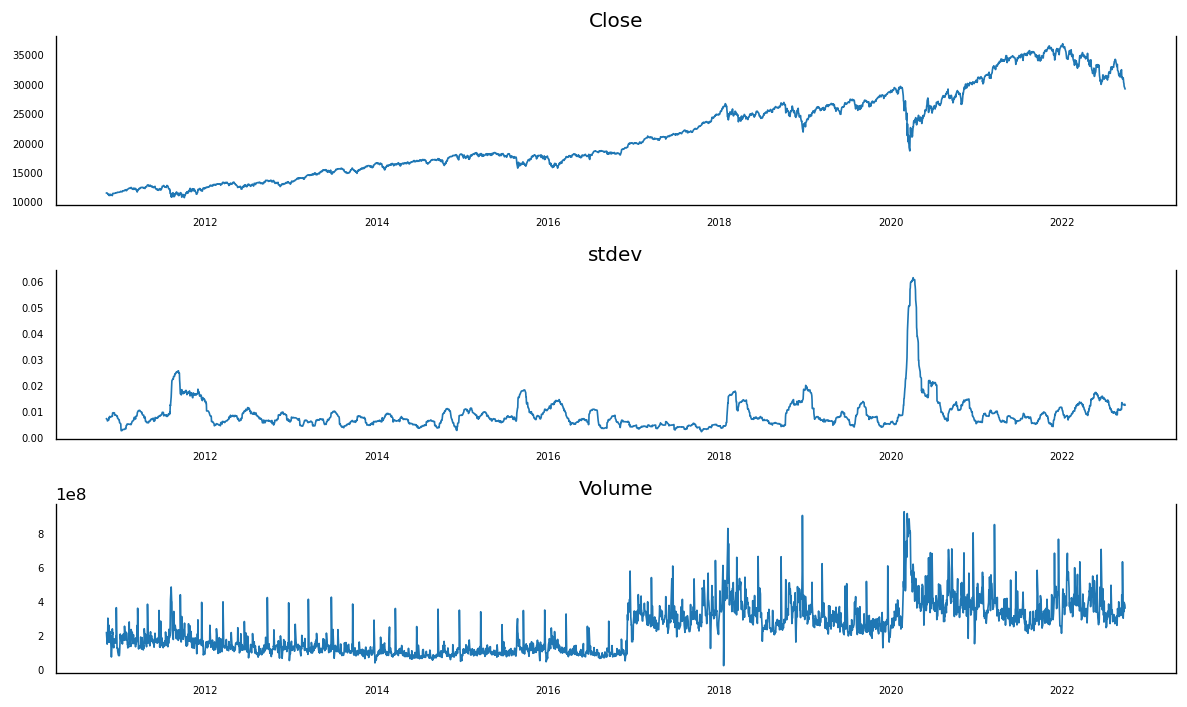

In [4]:
# Plot dataset
plot_grid(df_DJI[['Close', 'stdev', 'Volume']], 3, 1)

In [5]:
# Check stationarity
def check_stationarity(df):
    non_stationary = []
    for column in df:
        adfuller_res = adfuller(df[column][1:])
        adf_stat = adfuller_res[0]
        p_value = adfuller_res[1]
        ci_1 = adfuller_res[-2]['1%']
        ci_5 = adfuller_res[-2]['5%']
        print(f'ADF Statistic ({column}): {adf_stat}')
        print(f'p-value: {p_value}')
        if adf_stat > ci_1 or adf_stat > ci_5:
            non_stationary.append(column)
            print(f'{column} is non stationary.')
        else:
            print(f'{column} is stationary!')
    
    if len(non_stationary) > 0:
        print(f'Non-stationary columns are: {non_stationary}. Try .diff()')
        return non_stationary
    else:
        print(f'All columns are stationary!')
    
non_stationary = check_stationarity(df_DJI)

ADF Statistic (Open): -1.0773492073138655
p-value: 0.72401974532532
Open is non stationary.
ADF Statistic (High): -0.9619785824815071
p-value: 0.7668780076831763
High is non stationary.
ADF Statistic (Low): -1.153033424480215
p-value: 0.6934664811956492
Low is non stationary.
ADF Statistic (Close): -0.9443822493817242
p-value: 0.7730057164182885
Close is non stationary.
ADF Statistic (Volume): -2.440460022981442
p-value: 0.1306408830319179
Volume is non stationary.
ADF Statistic (stdev): -4.817917586531257
p-value: 5.025235839451884e-05
stdev is stationary!
Non-stationary columns are: ['Open', 'High', 'Low', 'Close', 'Volume']. Try .diff()


In [6]:
# Apply one .diff() on non stationary columns
df_DJI_stationary = pd.concat([df_DJI[non_stationary].diff(), df_DJI.drop(columns=non_stationary)], axis=1).dropna()

In [7]:
# Check stationarity again
check_stationarity(df_DJI_stationary)

ADF Statistic (Open): -35.85249601186087
p-value: 0.0
Open is stationary!
ADF Statistic (High): -12.116164813540804
p-value: 1.8703098419160416e-22
High is stationary!
ADF Statistic (Low): -17.19574683127315
p-value: 6.508232562291788e-30
Low is stationary!
ADF Statistic (Close): -11.027409416871846
p-value: 5.781341899201385e-20
Close is stationary!
ADF Statistic (Volume): -17.04605652564834
p-value: 8.132326028012831e-30
Volume is stationary!
ADF Statistic (stdev): -4.815456159623032
p-value: 5.080178779848281e-05
stdev is stationary!
All columns are stationary!


In [8]:
# Scale the data with MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df_DJI_stationary)
df_DJI_scaled = scaler.transform(df_DJI_stationary)
df_DJI_scaled = pd.DataFrame(df_DJI_scaled, columns=df_DJI.columns).dropna()

# Number of .diff() methods performed for stationary conversion
n_diffs = 1

# Number of days in test & train set
n_train = 2500
n_test = len(df_DJI) - n_train - n_diffs - stdev_window

# Split data
df_train = df_DJI_scaled.iloc[:n_train]
df_test = df_DJI_scaled.iloc[n_train:n_test+n_train]

# Create separate test set to preserve index for plotting predictions later
df_DJI_test = df_DJI.iloc[n_train:n_test+n_train]

print(f'Number of training days: {n_train}')
print(f'Number of testing days: {n_test}')

display(df_train.head(3))
display(df_test.head(3))

Number of training days: 2500
Number of testing days: 460


,Open,High,Low,Close,Volume,stdev
0,0.001785,-0.006747,-0.014256,-0.012425,-0.114305,0.113270
1,-0.014856,-0.010455,-0.027297,-0.020049,0.030259,0.102670
2,-0.025117,-0.031121,-0.022159,0.003433,0.003817,0.102662


,Open,High,Low,Close,Volume,stdev
2500,0.087701,0.008609,0.050436,-0.009372,0.026529,0.170192
2501,-0.092495,-0.141905,-0.358652,-0.216940,0.096182,0.176443
2502,-0.220933,-0.270638,0.040389,-0.074135,-0.058377,0.178097


In [9]:
# Split exogenous and endogenous variables
# endog = df_train.drop(columns=['Volume'])
# exog = df_train['Volume']

# Create VARMAX Model
model = VARMAX(
    df_train,
    order=(1,1),
    # error_cov_type='diagonal',
    filter_concentrated=True
)

# Fit model
model_fit = model.fit(disp=True)
# model_fit.summary()

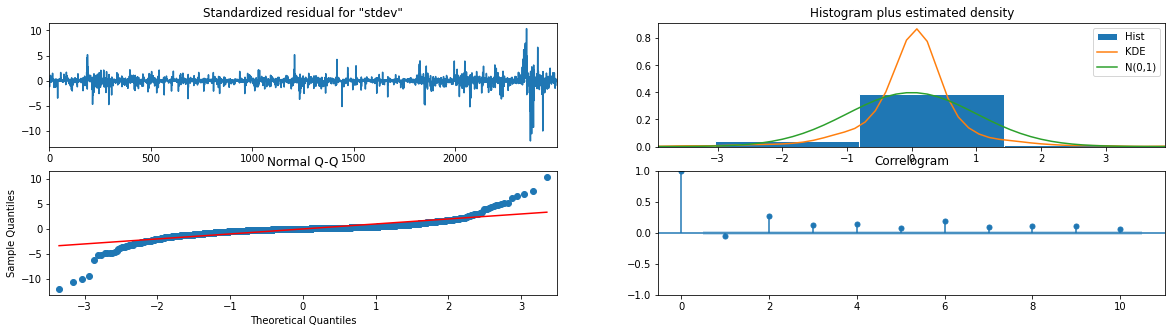

In [10]:
# Plot stdev diagnostics
model_fit.plot_diagnostics(5,figsize=(20,5));

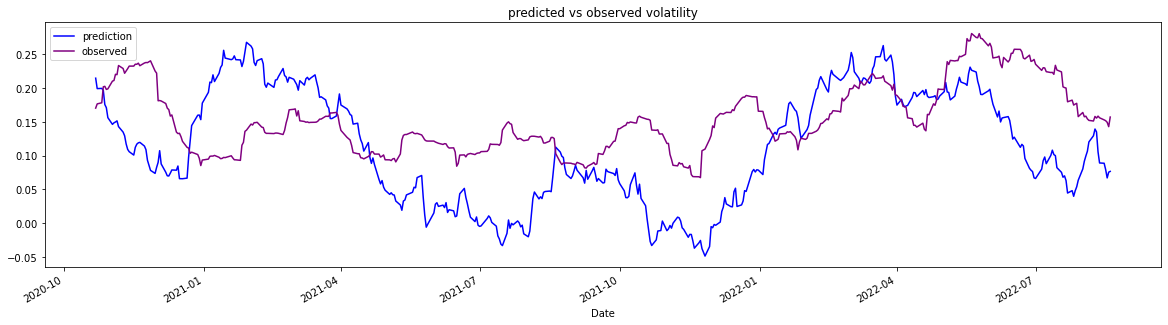

In [11]:
# Set random seed
np.random.seed(1)

# Plot predicted vs observed volatility
pred = pd.DataFrame(index=df_DJI_test.index)
pred['prediction'] = model_fit.simulate(n_test).set_index(pred.index, drop=True).stdev
pred['observed'] = df_test.set_index(pred.index, drop=True).stdev
pred.plot(figsize=(20,5),title='predicted vs observed volatility',color=['blue','purple'])
plt.legend(loc=('upper left'));

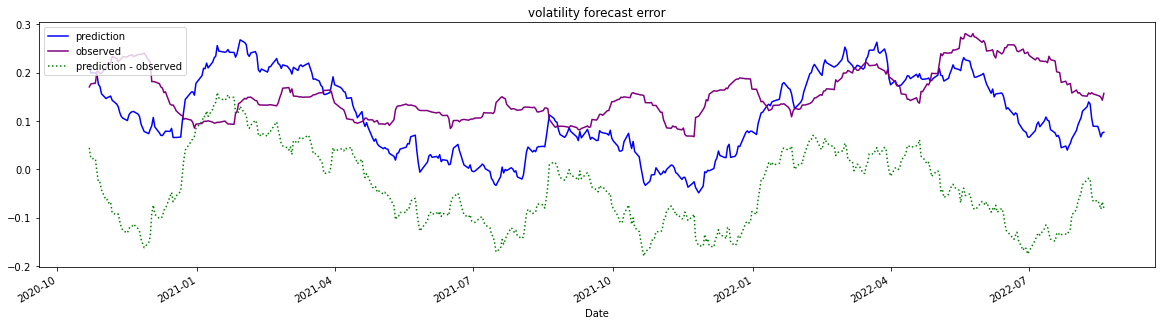

In [12]:
# Plot error
pred['prediction - observed'] = pred['prediction'] - pred['observed']
pred.plot(figsize=(20,5),title='volatility forecast error',color=['blue','purple','green'],style=['-','-',':'])
plt.legend(loc=('upper left'));

In [13]:
error_total = np.round(np.sum(np.abs(pred['prediction - observed'])), 2)
print(f'Total Error: {error_total}')

Total Error: 34.99


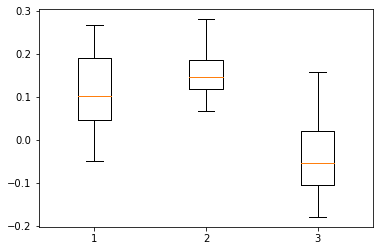

In [14]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.boxplot(pred)
plt.show()

In [15]:
pred.describe()[min]

count    460.000000
mean       0.153779
std        0.050015
min        0.067292
25%        0.117248
50%        0.146444
75%        0.185306
max        0.280622
Name: observed, dtype: float64

In [16]:
pred

,prediction,observed,prediction - observed
Date,,,
2020-10-22,0.214513,0.170192,0.044321
2020-10-23,0.199087,0.176443,0.022644
2020-10-26,0.199393,0.178097,0.021296
2020-10-27,0.196567,0.201750,-0.005183
2020-10-28,0.175546,0.202442,-0.026897
...,...,...,...
2022-08-15,0.088582,0.152779,-0.064197
2022-08-16,0.079248,0.151554,-0.072306
2022-08-17,0.066844,0.149197,-0.082353


In [17]:
pred['signal'] =  np.where(pred['prediction']>pred["observed"].describe().loc["min"], 1,
        np.where(pred["prediction"]<pred["observed"].describe().loc["max"], -1,
        0))

In [18]:
pred

,prediction,observed,prediction - observed,signal
Date,,,,
2020-10-22,0.214513,0.170192,0.044321,1
2020-10-23,0.199087,0.176443,0.022644,1
2020-10-26,0.199393,0.178097,0.021296,1
2020-10-27,0.196567,0.201750,-0.005183,1
2020-10-28,0.175546,0.202442,-0.026897,1
...,...,...,...,...
2022-08-15,0.088582,0.152779,-0.064197,1
2022-08-16,0.079248,0.151554,-0.072306,1
2022-08-17,0.066844,0.149197,-0.082353,-1


In [19]:
ic_25 = df_train['stdev'].describe()['25%']
ic_75 = df_train['stdev'].describe()['75%']
print(ic_25)
print(ic_75)

0.08756692364188422
0.15892908983477075


In [26]:
df_trading = pred[['observed', 'prediction']]
df_trading['signal'] = 0.0
df_trading.head(3)

,observed,prediction,signal
Date,,,
2020-10-22,0.170192,0.214513,0.0
2020-10-23,0.176443,0.199087,0.0
2020-10-26,0.178097,0.199393,0.0


In [27]:
def get_signals(df):  
    df['signal'] = np.where(df["prediction"]>df["observed"].describe().loc["25%"], 1,\
                            np.where(df["prediction"]<df["observed"].describe().loc["75%"], -1,0))

    print(df_trading['signal'].value_counts())
    
get_signals(df_trading)

-1    250
 1    210
Name: signal, dtype: int64


In [23]:
df_trading['signal']

Date
2020-10-22    1
2020-10-23    1
2020-10-26    1
2020-10-27    1
2020-10-28    1
             ..
2022-08-15   -1
2022-08-16   -1
2022-08-17   -1
2022-08-18   -1
2022-08-19   -1
Name: signal, Length: 460, dtype: int32

In [31]:
def trading_algo(df): 
    if df[df['prediction - observed'] >= 0.1]:
        print('sell')
    elif df[df['prediction - observed'] == 1]: 
        print('idk')
    elif df[df['prediction - observed'] < 0]:
        print('buy')
    else: 
        print('no_change')
        
    return portfolio_choice

In [33]:
df_trading

,observed,prediction,signal
Date,,,
2020-10-22,0.170192,0.214513,1
2020-10-23,0.176443,0.199087,1
2020-10-26,0.178097,0.199393,1
2020-10-27,0.201750,0.196567,1
2020-10-28,0.202442,0.175546,1
...,...,...,...
2022-08-15,0.152779,0.088582,-1
2022-08-16,0.151554,0.079248,-1
2022-08-17,0.149197,0.066844,-1


In [116]:

import os 
directory = ('./DATA/ETF_CYC')

cyclical_etfs = pd.DataFrame()


for root,dirs, files in os.walk(directory):
    for filename in files: 
        cyc_path  = (os.path.join(root, filename))


        cyc_df = pd.read_csv(cyc_path, parse_dates=True, infer_datetime_format=True, index_col='Date')
        cyc_df.rename(columns={'Close': cyc_path[-7:-4]}, inplace=True)
        cyclical_etfs = pd.concat([cyclical_etfs, cyc_df.pct_change()], axis=1)
        cyclical_etfs.dropna(inplace=True)
        
cyclical_etfs.index=pd.to_datetime(cyclical_etfs.index.date)
cyclical_etfs
        
        

,ITB,IYC,PEJ,VCR,XLY
2010-09-29,-0.011570,-0.004551,-0.003077,-0.004809,-0.007113
2010-09-30,0.007525,-0.001960,-0.000617,-0.001487,-0.002687
2010-10-01,-0.003320,0.000654,0.006794,0.001862,0.001197
2010-10-04,-0.012490,-0.005886,-0.004294,-0.004274,-0.002093
2010-10-05,0.012648,0.018421,0.023413,0.021086,0.020971
...,...,...,...,...,...
2022-09-19,0.022472,0.012350,0.011914,0.013549,0.012030
2022-09-20,-0.019636,-0.017295,-0.007167,-0.018229,-0.016954
2022-09-21,-0.012312,-0.020899,-0.041248,-0.022242,-0.023675
2022-09-22,-0.012279,-0.023431,-0.028502,-0.024884,-0.023075


In [117]:
import os 
directory = ('./DATA/ETF_DEF')

defensive_etfs = pd.DataFrame()

for root,dirs, files in os.walk(directory):
    for filename in files: 
        def_path = (os.path.join(root, filename))
        
        def_df = pd.read_csv(def_path, parse_dates=True, infer_datetime_format=True, index_col='Date')
        def_df.rename(columns={'Close': def_path[-7:-4]}, inplace=True)
        defensive_etfs = pd.concat([defensive_etfs,def_df.pct_change()], axis=1)
        defensive_etfs.dropna(inplace=True)
    
    
defensive_etfs
defensive_etfs.index=pd.to_datetime(defensive_etfs.index.date)

In [118]:
defensive_etfs['return'] = defensive_etfs.sum(axis=1)

defensive_etfs['signal'] = df_trading['signal']
defensive_etfs.dropna(inplace=True)

defensive_etfs

,IYK,KXI,PBJ,VDC,XLP,return,signal
2020-10-22,0.003144,-0.000716,0.000586,0.001197,-0.000459,0.003751,1.0
2020-10-23,0.002742,0.003225,0.001756,0.001913,0.001839,0.011476,1.0
2020-10-26,-0.014195,-0.010359,-0.013735,-0.013129,-0.012846,-0.064264,1.0
2020-10-27,-0.002048,-0.004151,-0.000889,-0.002721,-0.002634,-0.012442,1.0
2020-10-28,-0.029322,-0.030446,-0.029359,-0.028014,-0.029202,-0.146343,1.0
...,...,...,...,...,...,...,...
2022-08-15,0.009967,0.007590,0.004270,0.009969,0.009932,0.041728,-1.0
2022-08-16,0.007632,0.005895,0.008716,0.011855,0.011277,0.045376,-1.0
2022-08-17,-0.004583,0.000651,-0.007165,-0.002665,-0.002853,-0.016615,-1.0
2022-08-18,0.001309,-0.002115,0.008491,0.003428,0.003381,0.014494,-1.0


In [119]:
cyclical_etfs['return'] = cyclical_etfs.sum(axis=1)

cyclical_etfs['signal'] = df_trading['signal']
cyclical_etfs.dropna(inplace=True)

cyclical_etfs

,ITB,IYC,PEJ,VCR,XLY,return,signal
2020-10-22,-0.025357,0.002823,0.015620,0.003662,0.002048,-0.001203,1.0
2020-10-23,0.021680,0.007038,0.002153,0.007912,0.008770,0.047553,1.0
2020-10-26,-0.036605,-0.021898,-0.031308,-0.017327,-0.019217,-0.126354,1.0
2020-10-27,-0.017438,-0.003811,-0.014575,0.001531,-0.000467,-0.034759,1.0
2020-10-28,-0.006352,-0.029487,-0.033119,-0.030500,-0.031604,-0.131061,1.0
...,...,...,...,...,...,...,...
2022-08-15,-0.004928,0.005791,0.000477,0.006199,0.006886,0.014426,-1.0
2022-08-16,0.005591,0.013387,0.012408,0.012744,0.011047,0.055177,-1.0
2022-08-17,-0.017156,-0.012642,-0.018855,-0.013244,-0.010753,-0.072651,-1.0
2022-08-18,0.000808,-0.000719,0.004804,-0.000106,-0.000292,0.004495,-1.0


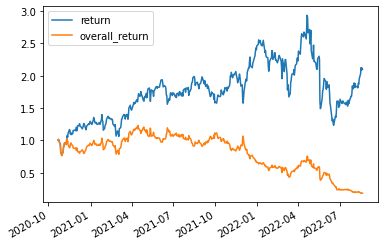

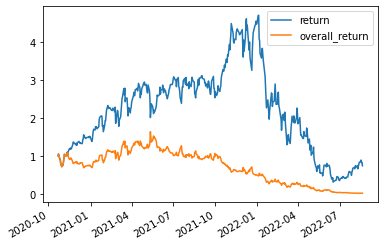

In [133]:
defensive_plot = (1 + defensive_etfs[['return', 'overall_return']]).cumprod().plot.line()
cyclical_plot = (1 + cyclical_etfs[['return', 'overall_return']]).cumprod().plot.line()